In [1]:
sd = 123 # Here sd means seed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.LstmStrategy as sl

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense,Dropout
from keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import random as rn


np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
tf.random.set_seed(sd)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
sd = 123 # Here sd means seed.
mpl.rcParams['figure.figsize'] = (16, 6)

In [9]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

#stock_list=['ICE', 'WLTW']
stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]
test_data['realcombo_before_std']=test_data.realcombo
#standard
realcombo_mean=test_data.realcombo.mean()
realcombo_std=test_data.realcombo.std()
test_data.realcombo=(test_data.realcombo-test_data.realcombo.mean())/test_data.realcombo.std()


In [10]:
test_data

,Date,ICE,WLTW,Dog_leash,realcombo,realcombo_before_std
0,2005-11-22,6.342704,69.851379,58.752772,2.643456,59.340512
1,2005-11-23,6.161225,69.651382,59.311547,2.655225,59.441256
2,2005-11-25,6.197519,69.724091,59.515885,2.656692,59.453819
3,2005-11-28,6.043263,68.378700,59.294517,2.529390,58.364055
4,2005-11-29,5.801895,67.324211,58.861839,2.452934,57.709551
...,...,...,...,...,...,...
3766,2020-11-09,98.220001,196.000000,24.116557,-0.406221,33.233881
3767,2020-11-10,98.000000,202.009995,27.773579,0.338432,39.608453
3768,2020-11-11,99.980003,202.949997,30.976658,0.064945,37.267276
3769,2020-11-12,98.309998,202.199997,34.950952,0.300618,39.284740


In [20]:
trendpredict=[]
count=-1
DAYSINAYEAR=200
for i in range(3300,test_data.shape[0]-DAYSINAYEAR):
    count=count+1
    if count%100==0 and count>1:
        print(f'completed 100. on iteration {i}')
    for sd in [123,789,456,329]:
        future=sl.build_model_and_predict(test_data,i,i+DAYSINAYEAR,seed=sd)
        trend=sl.trendHelper(future)
        print(f'idx {i+DAYSINAYEAR} seed {sd} predicted: {trend}')
        if trend != '-':
            break;
    trendpredict.append([i+DAYSINAYEAR,test_data.iloc[i+DAYSINAYEAR,0],trend,sd]) 
#trendpredict    
#profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
#print(profit_cumulative)

idx 3500 seed 123 predicted: UP
idx 3501 seed 123 predicted: UP
idx 3502 seed 123 predicted: UP
idx 3503 seed 123 predicted: UP
idx 3504 seed 123 predicted: UP
idx 3505 seed 123 predicted: UP
idx 3506 seed 123 predicted: UP
idx 3507 seed 123 predicted: UP
idx 3508 seed 123 predicted: UP
idx 3509 seed 123 predicted: UP
idx 3510 seed 123 predicted: UP
idx 3511 seed 123 predicted: UP
idx 3512 seed 123 predicted: -
idx 3512 seed 789 predicted: UP
idx 3513 seed 123 predicted: UP
idx 3514 seed 123 predicted: UP
idx 3515 seed 123 predicted: -
idx 3515 seed 789 predicted: UP
idx 3516 seed 123 predicted: UP
idx 3517 seed 123 predicted: UP
idx 3518 seed 123 predicted: UP
idx 3519 seed 123 predicted: -
idx 3519 seed 789 predicted: -
idx 3519 seed 456 predicted: -
idx 3519 seed 329 predicted: -
idx 3520 seed 123 predicted: -
idx 3520 seed 789 predicted: -
idx 3520 seed 456 predicted: UP
idx 3521 seed 123 predicted: UP
idx 3522 seed 123 predicted: UP
idx 3523 seed 123 predicted: UP
idx 3524 seed 12

idx 3670 seed 123 predicted: -
idx 3670 seed 789 predicted: -
idx 3670 seed 456 predicted: DOWN
idx 3671 seed 123 predicted: DOWN
idx 3672 seed 123 predicted: DOWN
idx 3673 seed 123 predicted: DOWN
idx 3674 seed 123 predicted: DOWN
idx 3675 seed 123 predicted: -
idx 3675 seed 789 predicted: -
idx 3675 seed 456 predicted: -
idx 3675 seed 329 predicted: -
idx 3676 seed 123 predicted: DOWN
idx 3677 seed 123 predicted: DOWN
idx 3678 seed 123 predicted: DOWN
idx 3679 seed 123 predicted: DOWN
idx 3680 seed 123 predicted: DOWN
idx 3681 seed 123 predicted: DOWN
idx 3682 seed 123 predicted: DOWN
idx 3683 seed 123 predicted: DOWN
idx 3684 seed 123 predicted: -
idx 3684 seed 789 predicted: DOWN
idx 3685 seed 123 predicted: DOWN
idx 3686 seed 123 predicted: -
idx 3686 seed 789 predicted: DOWN
idx 3687 seed 123 predicted: DOWN
idx 3688 seed 123 predicted: UP
idx 3689 seed 123 predicted: UP
idx 3690 seed 123 predicted: DOWN
idx 3691 seed 123 predicted: DOWN
idx 3692 seed 123 predicted: DOWN
idx 3693

In [21]:
trend_prediction=pd.DataFrame(trendpredict, columns=('day_index','lastdateIncludedInModel', 'trend_predict','seed'))
trend_prediction.to_csv('./data/IW_lstmmodel_trend_predict_v2_3500_3770_2.csv')
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
print(profit_cumulative)
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
transaction_list_pd.to_csv('./data/IW_lstmmodel_transaction_records_v2_3500_3770_2.csv')

8.879648124939791


In [7]:
#profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
#print(profit_cumulative)
#transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
#transaction_list_pd.to_csv('./data/BB_lstmmodel_transaction_records_v2_1260_1546.csv')

38.37129313607518


In [17]:
print(profit_cumulative)

30.2716098700285


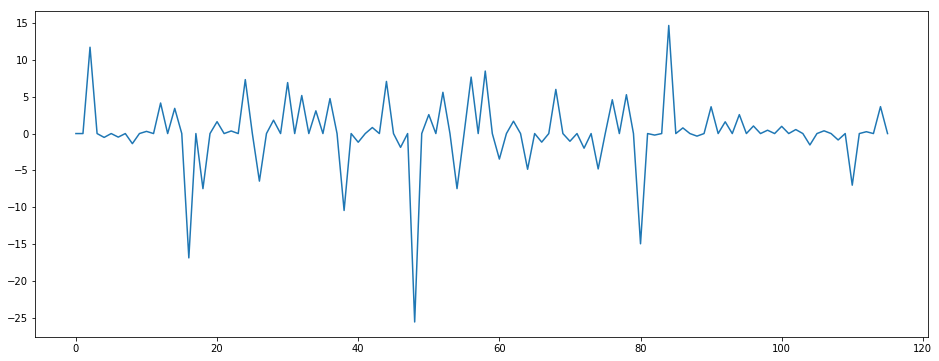

In [22]:
plt.plot(transaction_list_pd.profit)

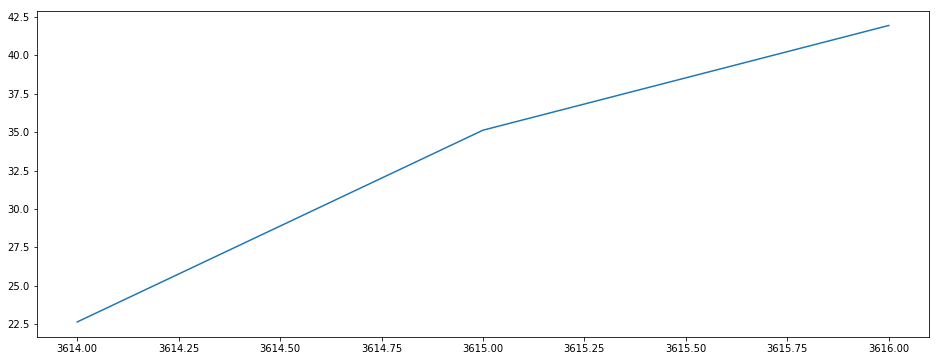

In [19]:
#2757	11/4/16 0:00	O	L	0	UP
#2883	5/9/17 0:00	C	L	15.44655386	DOWN
plt.plot(test_data.realcombo_before_std.iloc[3614:3617])

(201,)
Epoch 00055: early stopping
score on all train data is: 69.67%


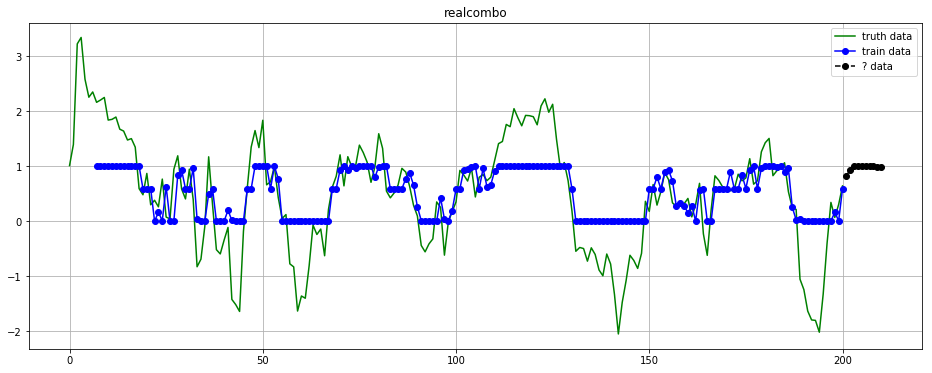

UP


In [30]:
sd=123
starting_point=3770-200
future=sl.build_model_and_predict_and_show(test_data,starting_point,starting_point+200,7)
print(sl.trendHelper(future))

[1.0, 0.99999976, 0.999996, 0.99994797, 0.55443513, 0.5649317, 0.34614605, 0.30958536, 0.23360142, 0.24463764]
[0, 0, 0, -1.3774043, 0, -0.6764257, 0, 0, 0]
[0, 0, -3.0088458120233574, 3.0088458120233574, -1.4776057932200277, 1.4776057932200277, 0, 0]


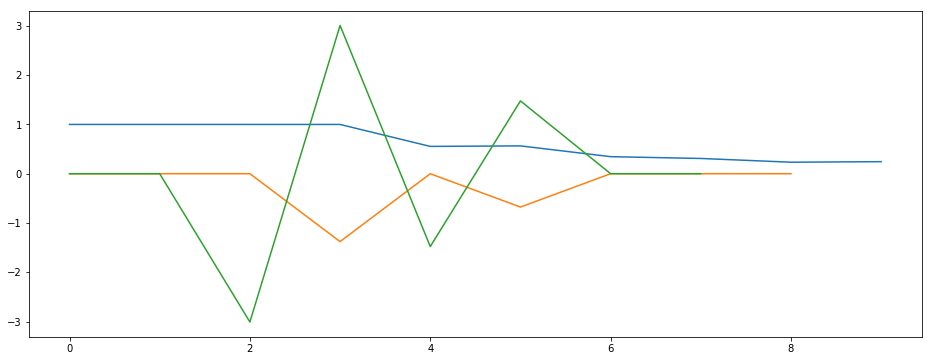

DOWN


In [11]:
future_diff1=sl.differentialHelper(future)
future_diff2=sl.differentialHelper(future_diff1)
print(future)
print(future_diff1)
print(future_diff2)
plt.plot(future)
plt.plot(future_diff1)
plt.plot(future_diff2)
plt.show()
print(sl.trendHelper(future))

# From trend to transaction

In [9]:
trendpredict=pd.read_csv('./data/lstmmodel_trend_predict_2200_3770.csv',header=0)
trendpredict.head()

,index,trend,seed
0,2200,DOWN,123
1,2201,UP,123
2,2202,DOWN,123
3,2203,DOWN,123
4,2204,DOWN,123


In [12]:
trendpredict.trend.value_counts()

UP      486
DOWN    271
-        36
Name: trend, dtype: int64

In [13]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict.to_numpy(),test_data)

In [14]:
print(profit_cumulative)

264.0775977304936


In [16]:
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2200_3770.csv')

In [19]:
transaction_list_pd.set_index('date')

,day_index,open_close,L/S,profit,trend_predicted,combo_price
date,,,,,,
-,-1,-,-,0.000000,-,0.000000
2014-08-21 00:00:00,2200,O,S,0.000000,DOWN,41.785390
2014-08-22 00:00:00,2201,C,S,0.657800,UP,41.127590
2014-08-22 00:00:00,2201,O,L,0.000000,UP,41.127590
2014-08-25 00:00:00,2202,C,L,0.235860,DOWN,41.363450
...,...,...,...,...,...,...
2020-10-13 00:00:00,3747,O,L,0.000000,UP,42.442671
2020-10-14 00:00:00,3748,C,L,0.543436,DOWN,42.986107
2020-10-14 00:00:00,3748,O,S,0.000000,DOWN,42.986107


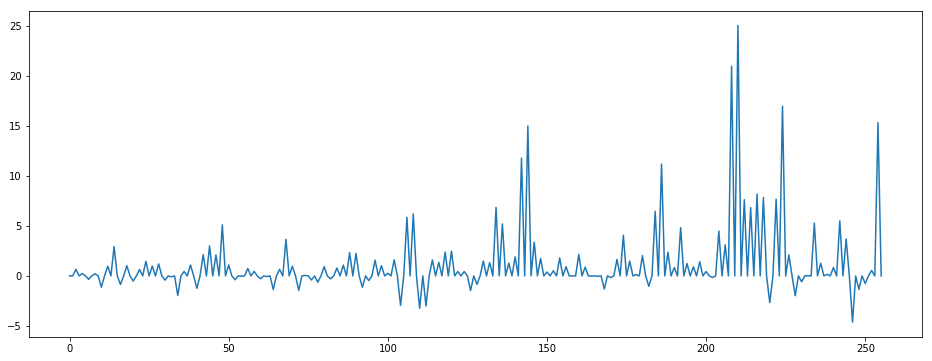

In [24]:
transaction_list_pd['profit'].plot()